In [12]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
import re
from tqdm import tqdm


In [13]:
orig_matrix = pd.read_csv('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/mutation_matrix.csv', sep='\t', index_col=0)
orig_matrix


,TCGA-4P-AA8J,TCGA-BA-4074,TCGA-BA-4075,TCGA-BA-4076,TCGA-BA-4077,TCGA-BA-4078,TCGA-BA-5149,TCGA-BA-5151,TCGA-BA-5152,TCGA-BA-5153,...,TCGA-UF-A7JH,TCGA-UF-A7JJ,TCGA-UF-A7JK,TCGA-UF-A7JO,TCGA-UF-A7JS,TCGA-UF-A7JT,TCGA-UF-A7JV,TCGA-UP-A6WW,TCGA-WA-A7GZ,TCGA-WA-A7H4
_96_class,,,,,,,,,,,,,,,,,,,,,
A[C>A]A,3.0,3.0,1.0,10.0,9.0,13.0,1.0,2.0,6.0,0.0,...,0.0,1.0,2.0,1.0,2.0,2.0,0.0,1.0,4.0,0.0
A[C>A]C,1.0,0.0,0.0,7.0,0.0,8.0,1.0,1.0,0.0,0.0,...,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0
A[C>A]G,3.0,1.0,1.0,12.0,2.0,12.0,0.0,0.0,1.0,1.0,...,0.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
A[C>A]T,0.0,1.0,0.0,8.0,0.0,4.0,1.0,1.0,0.0,0.0,...,1.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
A[C>G]A,5.0,1.0,2.0,4.0,22.0,10.0,4.0,0.0,42.0,0.0,...,0.0,1.0,0.0,7.0,4.0,13.0,5.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T[T>C]T,2.0,2.0,5.0,3.0,1.0,3.0,2.0,1.0,0.0,0.0,...,0.0,1.0,4.0,2.0,1.0,0.0,0.0,0.0,4.0,0.0
T[T>G]A,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
T[T>G]C,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
import os
import pandas as pd
from tqdm import tqdm

base_sig = '/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Signature'
base_exp = '/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Exposure'
dims     = [f'dim_{d}' for d in range(2,26)]

# If you still want to collect all M_hats in a nested dict, you can.
# But note this will still grow large. Prefer to compute & discard or
# reduce to summaries (errors, stabilities) as you go.
M_hats = {}
KL_scores = {}

for dim in tqdm(dims):
    sig_dir = os.path.join(base_sig, dim)
    exp_dir = os.path.join(base_exp, dim)
    
    # sorted lists of filenames
    sig_files = sorted(f for f in os.listdir(sig_dir) if f.endswith('.csv'))
    exp_files = sorted(f for f in os.listdir(exp_dir) if f.endswith('.csv'))
    
    # assume they align one-to-one by sort order
    runs = min(len(sig_files), len(exp_files))
    kl_list = []
    M_hats_dim = {}
    
    for run_idx in range(runs):
        # read one Signature file
        sig_fn = sig_files[run_idx]
        S_r = pd.read_csv(os.path.join(sig_dir, sig_fn),
                          index_col=0)
        # tag its columns
        run_label = f"_run_{run_idx+1}"
        S_r.columns = [c+run_label for c in S_r.columns]
        
        # read one Exposure file
        exp_fn = exp_files[run_idx]
        A_r = pd.read_csv(os.path.join(exp_dir, exp_fn),
                          index_col=0)
        # exposure is a row per signature, so tag the index
        A_r.index = [idx+run_label for idx in A_r.index]
        
        # now pick the same run columns/rows
        sig_cols = S_r.columns.tolist()      # k of them
        # A_r.loc picks those rows and leaves samples as columns
        A_rr     = A_r.loc[sig_cols]         # shape (k, n_samples)
        
        # reconstruct
        M_hat = S_r.dot(A_rr)          # contexts × samples
        
        # compute KL divergence: sum_{i,j} [M log(M/Mhat) - M + Mhat]
        eps    = 1e-9
        M_safe    = orig_matrix + eps
        Mhat_safe = M_hat       + eps
        
        kl_matrix = (M_safe * np.log(M_safe / Mhat_safe)
                     - M_safe
                     + Mhat_safe)
        kl_value  = kl_matrix.values.sum()
        kl_list.append(kl_value)
        
        # discard per‐run arrays before next iteration
        del S_r, A_r, A_rr, M_hat, kl_matrix
        
    # store average KL for this dim
    KL_scores[dim] = float(np.mean(kl_list))
    M_hats[dim] = M_hats_dim


100%|██████████| 24/24 [00:30<00:00,  1.29s/it]


In [15]:
# list all files under /Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Signature/dim_2/
dims = ['dim_' + str(dim) for dim in list(range(2, 26))] 
df_dims = {}

for dim in dims: 
    # get all files in the directory
    path = os.path.join('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Signature', dim)
    exposure_path = os.path.join('/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_3/Amy/Output/Exposure', dim)
    files = os.listdir(path)
    
    # filter for only .csv files
    csv_files = [f for f in files if f.endswith('.csv')]
    
    # create a list to hold the dataframes
    dfs = []
    
    # loop through the csv files and read them into dataframes
    count = 1
    for file in csv_files:
        df = pd.read_csv(os.path.join(path, file), index_col=0)
        df.columns = [col + '_run_' + str(count) for col in df.columns]  # replace spaces with underscores
        count += 1
        dfs.append(df)
    
    # concatenate the dataframes into one dataframe
    combined_df = pd.concat(dfs, axis = 1)
    df_dims[dim] = combined_df


In [16]:
cluster_centroids = {}

for dim in df_dims.keys():
    kmeans = KMeans(n_clusters=int(dim.split('_')[1]))
    kmeans.fit(df_dims[dim].T) 
    cluster_centroids[dim] = kmeans.cluster_centers_


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

cluster_centroids = {}
cluster_stability = {}
silhouette = {}

for dim, df in df_dims.items():
    k = int(dim.split('_')[1])
    X = df.T                              # shape = (n_runs, 96)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    centroids = kmeans.cluster_centers_   # shape = (k, 96)

    labels = kmeans.labels_
    sil_vals = silhouette_samples(X, labels)
    stability = {i: sil_vals[labels==i].mean()
                 for i in range(k)}

    cluster_centroids[dim] = centroids
    cluster_stability[dim] = stability

    print(f"{dim}: overall silhouette = {silhouette_score(X, labels):.3f}")
    silhouette[dim] = silhouette_score(X, labels)


dim_2: overall silhouette = 0.811
dim_3: overall silhouette = 0.708
dim_4: overall silhouette = 0.504
dim_5: overall silhouette = 0.424
dim_6: overall silhouette = 0.353
dim_7: overall silhouette = 0.325
dim_8: overall silhouette = 0.324
dim_9: overall silhouette = 0.331
dim_10: overall silhouette = 0.331
dim_11: overall silhouette = 0.333
dim_12: overall silhouette = 0.320
dim_13: overall silhouette = 0.328
dim_14: overall silhouette = 0.323
dim_15: overall silhouette = 0.318
dim_16: overall silhouette = 0.319
dim_17: overall silhouette = 0.355
dim_18: overall silhouette = 0.337
dim_19: overall silhouette = 0.355
dim_20: overall silhouette = 0.330
dim_21: overall silhouette = 0.388
dim_22: overall silhouette = 0.354
dim_23: overall silhouette = 0.391
dim_24: overall silhouette = 0.391
dim_25: overall silhouette = 0.397


<Figure size 1200x600 with 0 Axes>

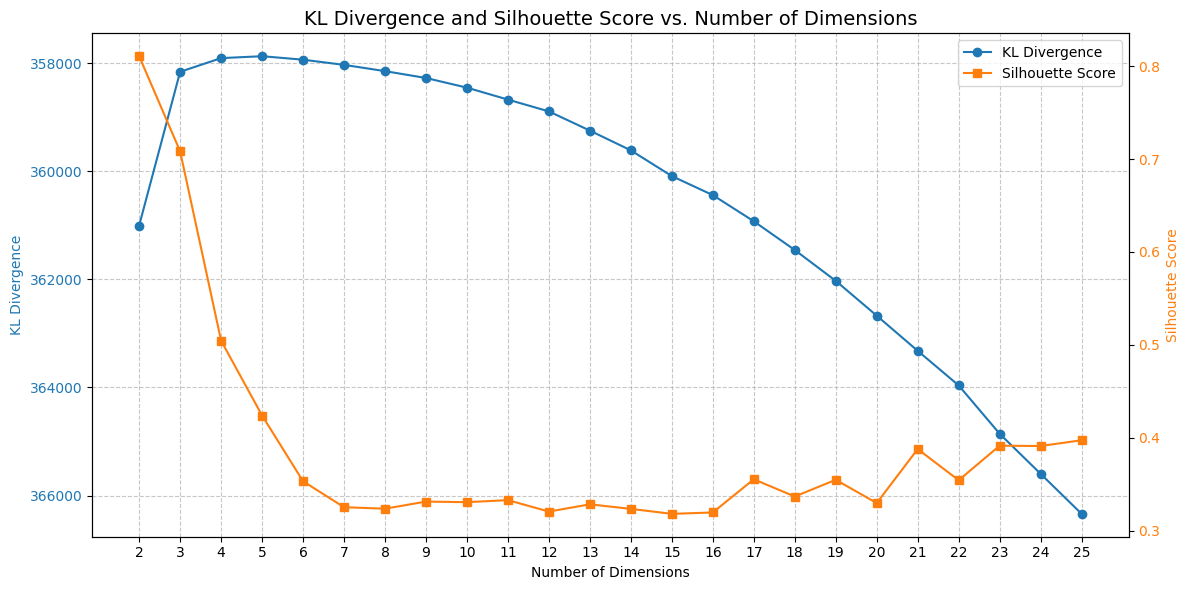

In [18]:
# plot the values of the dict KL_scores and silhouette
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a plot with primary y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract dimension numbers for x-axis (cleaner labels)
dim_numbers = [int(dim.split('_')[1]) for dim in KL_scores.keys()]

# Plot KL_scores on primary y-axis (left)
color1 = 'tab:blue'
ax1.set_xlabel('Number of Dimensions')
ax1.set_ylabel('KL Divergence', color=color1)
ax1.plot(dim_numbers, list(KL_scores.values()), marker='o', color=color1, label='KL Divergence')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.7)

# Invert y-axis for KL score so that lower (better) values are at the top
ax1.invert_yaxis()

# Create a secondary y-axis for silhouette scores
ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(dim_numbers, list(silhouette.values()), marker='s', color=color2, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color2)

# Add title and legend
plt.title('KL Divergence and Silhouette Score vs. Number of Dimensions', fontsize=14)

# Create unified legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

# Ensure x-axis shows integer values for dimensions
ax1.set_xticks(dim_numbers)

# Adjust layout
fig.tight_layout()
